<a href="https://colab.research.google.com/github/shihab-iiuc/Healthy_-Bird-_Detection/blob/main/B_for_Birds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Import necessary libraries
import torch
import torch.nn as nn
from torch.optim import Adam
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
import os
from sklearn.metrics import accuracy_score

# Define paths
dataset_path = '/content/drive/MyDrive/Colab Notebooks/B_for_Birds/Detection'  # Replace with your dataset path

# Hyperparameters
batch_size = 32
image_size = 224
initial_learning_rate = 0.001
epochs = 15
fine_tune_epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Augmentation and Transformation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.RandomRotation(30),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    'val': transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
}

# Datasets and DataLoaders
train_dataset = ImageFolder(os.path.join(dataset_path), transform=data_transforms['train'])
val_dataset = ImageFolder(os.path.join(dataset_path), transform=data_transforms['val'])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Load EfficientNet (EfficientNet-B0) and customize it for binary classification
model = models.efficientnet_b0(pretrained=True)
num_features = model.classifier[1].in_features  # Get input features of the classifier
model.classifier = nn.Sequential(
    nn.Linear(num_features, 128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128, 1),
    nn.Sigmoid(),  # Binary classification
)
model = model.to(device)

# Loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = Adam(model.parameters(), lr=initial_learning_rate)

# Training function
def train_model(model, criterion, optimizer, train_loader, val_loader, epochs):
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        print("-" * 30)

        # Training phase
        model.train()
        train_loss = 0.0
        train_preds = []
        train_targets = []
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device).float()
            optimizer.zero_grad()

            outputs = model(inputs).squeeze(1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_preds += torch.round(outputs).cpu().tolist()
            train_targets += labels.cpu().tolist()

        train_accuracy = accuracy_score(train_targets, train_preds)
        print(f"Training Loss: {train_loss / len(train_loader):.4f}, Training Accuracy: {train_accuracy:.4f}")

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_preds = []
        val_targets = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device).float()
                outputs = model(inputs).squeeze(1)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                val_preds += torch.round(outputs).cpu().tolist()
                val_targets += labels.cpu().tolist()

        val_accuracy = accuracy_score(val_targets, val_preds)
        print(f"Validation Loss: {val_loss / len(val_loader):.4f}, Validation Accuracy: {val_accuracy:.4f}")

    return model

# Train the model
model = train_model(model, criterion, optimizer, train_loader, val_loader, epochs)

# Fine-tuning phase
for param in model.parameters():
    param.requires_grad = True  # Unfreeze all layers

# Lower learning rate for fine-tuning
optimizer = Adam(model.parameters(), lr=1e-5)

print("Starting fine-tuning...")
model = train_model(model, criterion, optimizer, train_loader, val_loader, fine_tune_epochs)

# Save the final model
torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/B_for_Birds/budgerigar_health_final_model.pth')
print("Model saved!")

# Evaluate the model
def evaluate_model(model, val_loader):
    model.eval()
    val_preds = []
    val_targets = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device).float()
            outputs = model(inputs).squeeze(1)
            val_preds += torch.round(outputs).cpu().tolist()
            val_targets += labels.cpu().tolist()

    accuracy = accuracy_score(val_targets, val_preds)
    return accuracy

val_accuracy = evaluate_model(model, val_loader)
print(f"Final Validation Accuracy: {val_accuracy:.2f}")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 64.5MB/s]


Epoch 1/15
------------------------------
Training Loss: 0.4585, Training Accuracy: 0.7744
Validation Loss: 0.3676, Validation Accuracy: 0.8685
Epoch 2/15
------------------------------
Training Loss: 0.2599, Training Accuracy: 0.9014
Validation Loss: 0.1744, Validation Accuracy: 0.9388
Epoch 3/15
------------------------------
Training Loss: 0.1802, Training Accuracy: 0.9274
Validation Loss: 0.0511, Validation Accuracy: 0.9841
Epoch 4/15
------------------------------
Training Loss: 0.1576, Training Accuracy: 0.9376
Validation Loss: 0.0698, Validation Accuracy: 0.9796
Epoch 5/15
------------------------------
Training Loss: 0.0898, Training Accuracy: 0.9728
Validation Loss: 0.0855, Validation Accuracy: 0.9717
Epoch 6/15
------------------------------
Training Loss: 0.0908, Training Accuracy: 0.9762
Validation Loss: 0.0334, Validation Accuracy: 0.9898
Epoch 7/15
------------------------------
Training Loss: 0.1296, Training Accuracy: 0.9467
Validation Loss: 0.0623, Validation Accuracy:

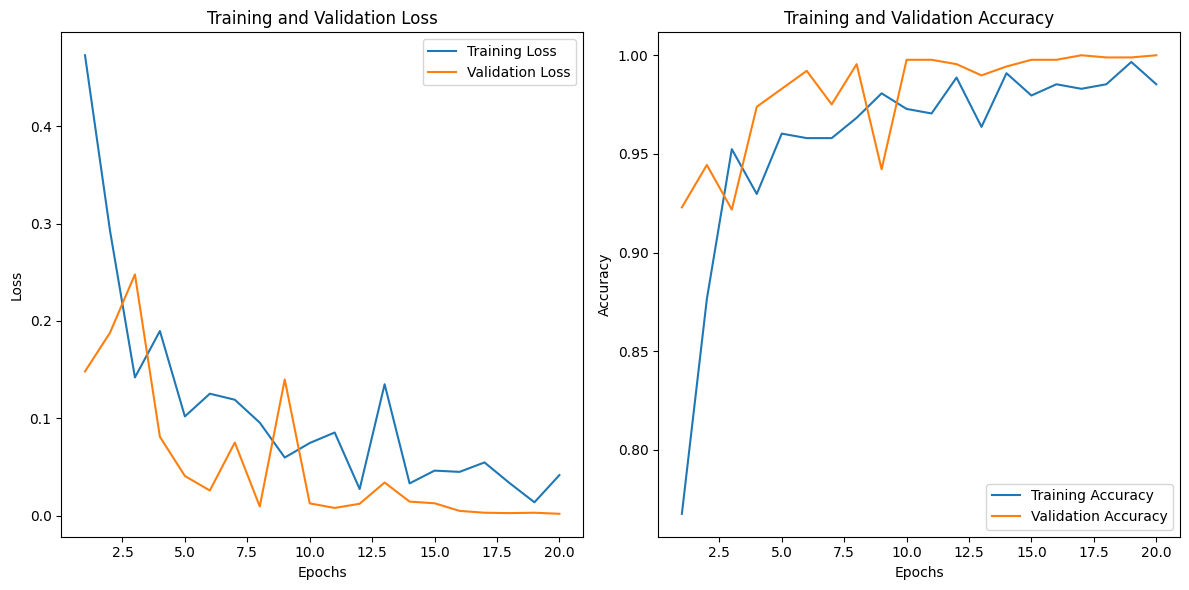

In [ ]:
import matplotlib.pyplot as plt



# Add your actual data for these lists
train_losses = [0.4726, 0.2929, 0.1421, 0.1897, 0.1021, 0.1254, 0.1192, 0.0957, 0.0599, 0.0748, 0.0856, 0.0276, 0.1351, 0.0334, 0.0465]
val_losses = [0.1482, 0.1879, 0.2478, 0.0812, 0.0410, 0.0261, 0.0753, 0.0097, 0.1400, 0.0129, 0.0082, 0.0125, 0.0343, 0.0147, 0.0130]
train_accuracies = [0.7676, 0.8764, 0.9524, 0.9297, 0.9603, 0.9580, 0.9580, 0.9683, 0.9807, 0.9728, 0.9705, 0.9887, 0.9637, 0.9909, 0.9796]
val_accuracies = [0.9229, 0.9444, 0.9218, 0.9739, 0.9830, 0.9921, 0.9751, 0.9955, 0.9422, 0.9977, 0.9977, 0.9955, 0.9898, 0.9943, 0.9977]

# Fine-tuning metrics (optional)
fine_tune_train_losses = [0.0452, 0.0549, 0.0338, 0.0140, 0.0419]
fine_tune_val_losses = [0.0052, 0.0033, 0.0029, 0.0033, 0.0022]
fine_tune_train_accuracies = [0.9853, 0.9830, 0.9853, 0.9966, 0.9853]
fine_tune_val_accuracies = [0.9977, 1.0000, 0.9989, 0.9989, 1.0000]

# Combine the metrics for the entire training and fine-tuning process
total_train_losses = train_losses + fine_tune_train_losses
total_val_losses = val_losses + fine_tune_val_losses
total_train_accuracies = train_accuracies + fine_tune_train_accuracies
total_val_accuracies = val_accuracies + fine_tune_val_accuracies

# Create epochs for x-axis
epochs = list(range(1, len(total_train_losses) + 1))

# Plot Loss Graph
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, total_train_losses, label="Training Loss")
plt.plot(epochs, total_val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

# Plot Accuracy Graph
plt.subplot(1, 2, 2)
plt.plot(epochs, total_train_accuracies, label="Training Accuracy")
plt.plot(epochs, total_val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
import torch
from torchvision import models
import torch.nn as nn

# Load the saved model
model_path = '/content/drive/MyDrive/Colab Notebooks/B_for_Birds/budgerigar_health_final_model.pth'
model = models.efficientnet_b0(pretrained=False)
num_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Linear(num_features, 128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128, 1),
    nn.Sigmoid()
)
model.load_state_dict(torch.load(model_path))
model.eval()  # Set model to evaluation mode
model = model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-2-5c9c9ec356ff>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions

In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import os
import matplotlib.pyplot as plt  # Import for displaying the image

# Paths
model_path = "/content/drive/MyDrive/Colab Notebooks/B_for_Birds/budgerigar_health_final_model.pth"
image_path = "/content/drive/MyDrive/Colab Notebooks/B_for_Birds/test/sick01.JPG"  # Replace with your image path

# Define the model architecture
from torchvision import models
import torch.nn as nn

# Load EfficientNet model
model = models.efficientnet_b0(pretrained=False)  # Use the same architecture
num_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Linear(num_features, 128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128, 1),
    nn.Sigmoid()
)

# Load the trained model weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

# Define image transformation (same as during training)
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load and preprocess the image
image = Image.open(image_path).convert("RGB")  # Ensure the image is in RGB mode

# Display the input image
plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.axis('off')  # Hide the axes
plt.title("Input Image")
plt.show()

# Apply transformations
transformed_image = image_transform(image)
transformed_image = transformed_image.unsqueeze(0)  # Add batch dimension

# Perform inference
with torch.no_grad():
    transformed_image = transformed_image.to(device)
    output = model(transformed_image).item()  # Get the model's prediction

# Interpret the result
threshold = 0.5  # Define a threshold for classification
if output >= threshold:
    print(f"Prediction: Normal (Confidence: {output:.4f})")
else:
    print(f"Prediction: Abnormal (Confidence: {1 - output:.4f})")


<ipython-input-5-fe0a86a49042>:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Colab Notebooks/B_for_Birds/test/sick02.JPG'